In [12]:
import networkx as nx
#from netgraph import Graph, InteractiveGraph
#from ipysigma import Sigma
#from pyvis.network import Network
from dotenv import load_dotenv
import matplotlib
import matplotlib.pyplot as plt
import os
import requests
# Elastic search info
SCANR_API_URL = os.environ.get('SCANR_API_URL')
SCANR_API_TOKEN = os.environ.get('SCANR_API_TOKEN')

SCANR_API_URL = 'https://cluster-staging.elasticsearch.dataesr.ovh/scanr-publications-dev-20230912/_search'
SCANR_API_TOKEN = 'c2NhbnItZnJvbnQ6cFh1UWtUY21NUUN3aE5zdQ=='
header = {'Authorization': 'Basic '+SCANR_API_TOKEN}

In [13]:
# Keywords list
keywords = ['open science']
#keywords=[]

# Create query block
must_block = []
for q in keywords :
    must_block.append( {
                    "query_string": {
                        "fields": ["title.default",
                        "title.fr", "title.en",
                                   "keywords.en", "keywords.fr", "keywords.default",
                                   "domains.label.default", "domains.label.fr", "domains.label.en",
                                   "summary.default", "summary.fr", "summary.en",
                                  "alternativeSummary.default", "alternativeSummary.fr", "alternativeSummary.en"],
                        "query": f'"{q}"'
                    }})

# Query json
json_query = {
        "size": 0,
        "query": {
            "bool": {
                "filter":[
                                   {
                       "terms": {"authors.role.keyword": ["author", "directeurthese"]}
                    },
                    {
                       "terms": {"year": [2018, 2019, 2020, 2021, 2022, 2023]}
                    } 
                ],
                "must": must_block
            }
        },
        "aggs":{
            "idref":{ "terms": {
                #"field": "co_institutions.keyword",
                #"field": "co_domains.keyword",
                "field": "co_domains.keyword",
                "size":1000
            }
                    }
        }
    }

# Request answer
json_answer = requests.post(SCANR_API_URL, json=json_query, headers=header).json()

In [14]:
len(json_answer['aggregations']['idref']['buckets'])

745

In [15]:
nodes = {}
for e in json_answer['aggregations']['idref']['buckets']:
    [node1, node2] = e['key'].split('---')
    weight = e['doc_count']
    if node1 not in nodes:
        nodes[node1] = {'nb_works': 0, 'name': node1}
    if node2 not in nodes:
        nodes[node2] = {'nb_works': 0, 'name': node2}
    nodes[node1]['nb_works']+=weight
    nodes[node2]['nb_works']+=weight

In [16]:
min_works = 5

# Init array
nb_aut_removed = []

# Create graph
G = nx.Graph()


for n in nodes:
    if nodes[n]['nb_works'] < min_works:
        continue
    G.add_node(n, size=nodes[n].get("work_count"))

# 1. Loop over all authors 
for e in json_answer['aggregations']['idref']['buckets']:
    [node1, node2] = e['key'].split('---')
    weight = e['doc_count']
    if nodes[node1]['nb_works'] >= min_works and nodes[node2]['nb_works'] >= min_works:
        G.add_edge(node1, node2, weight = weight)
    

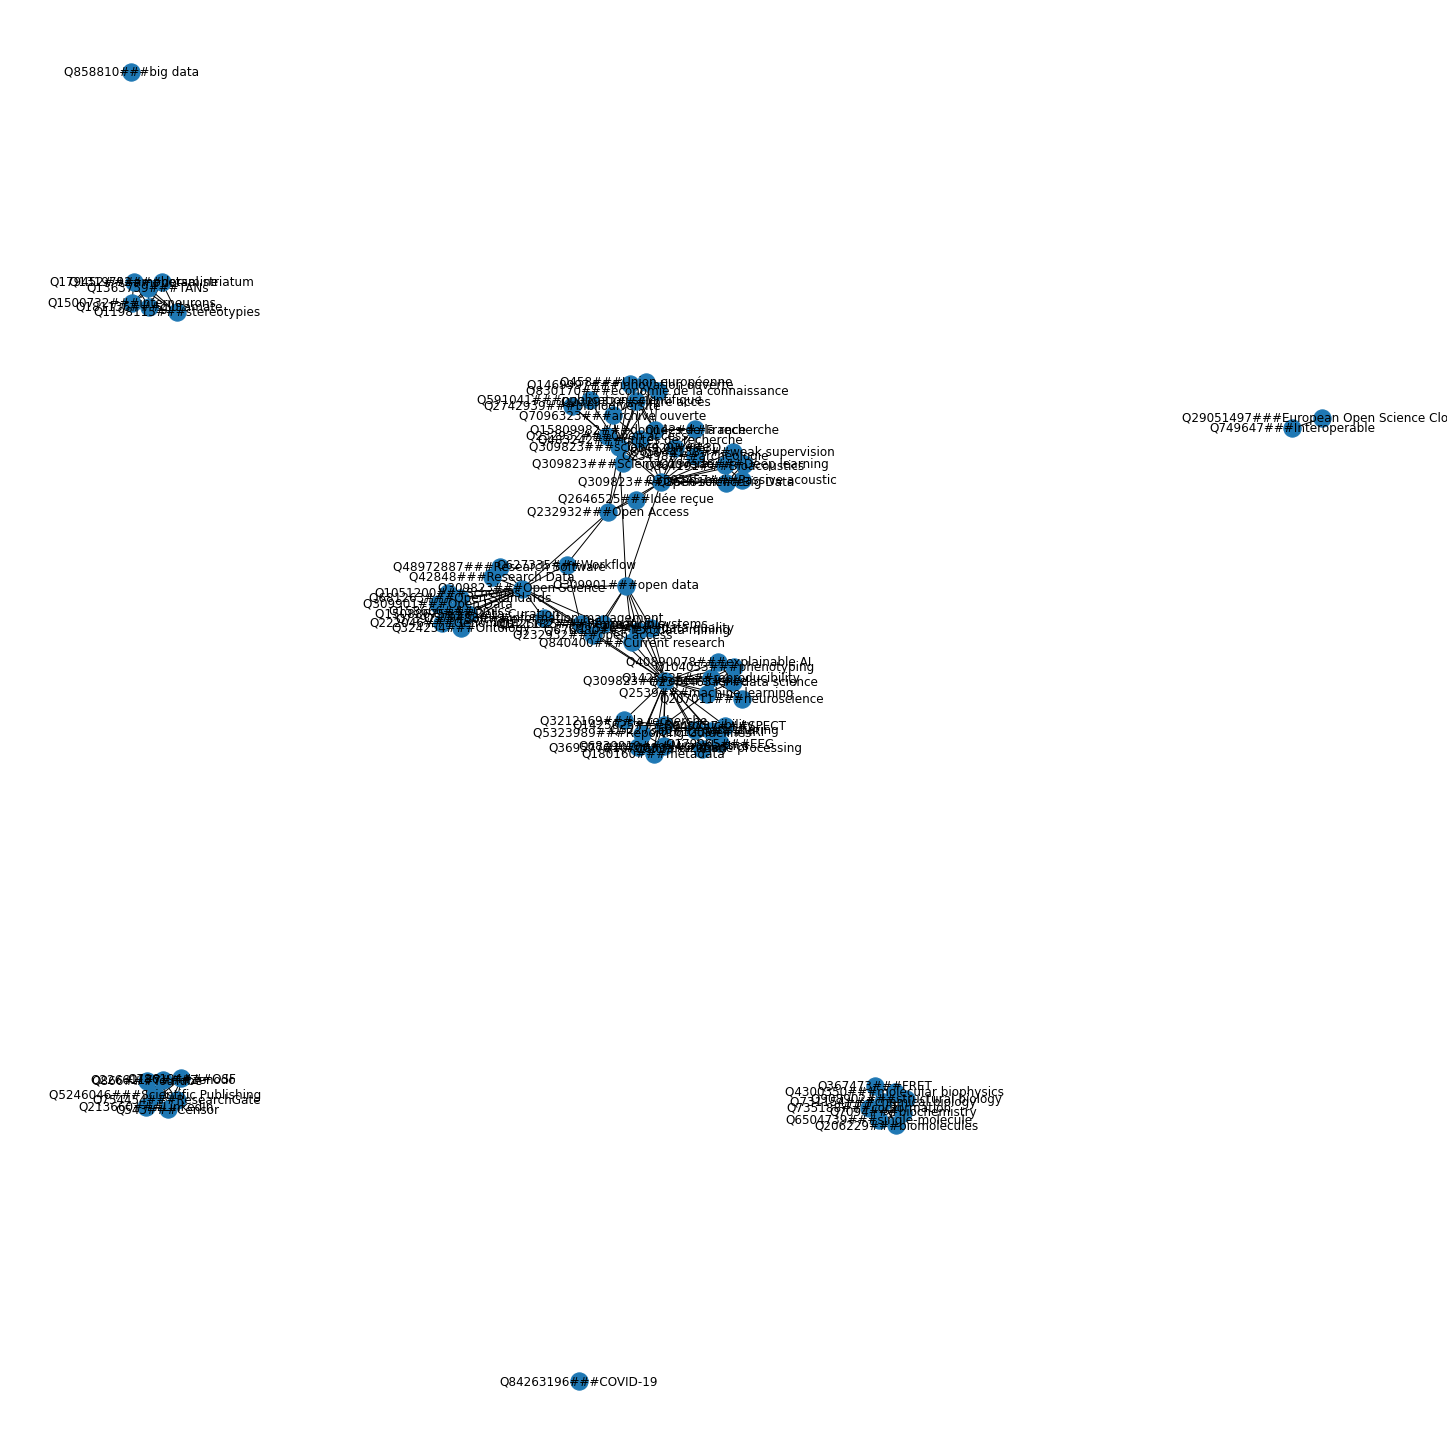

In [17]:
# Draw network
plt.figure(figsize=(20,20))
nx.draw(G, pos=nx.spring_layout(G), with_labels = True)
plt.draw()

In [18]:
communities_generator = nx.community.girvan_newman(G)
#C = next(communities_generator)[8]
C = next(communities_generator)[0]
len(C)

23

In [19]:

# Init array
nb_aut_removed = []

# Create graph
G2 = nx.Graph()


for n in nodes:
    if n not in C:
        continue
    G2.add_node(n, size=nodes[n].get("work_count"))

# 1. Loop over all authors 
for e in json_answer['aggregations']['idref']['buckets']:
    [node1, node2] = e['key'].split('---')
    weight = e['doc_count']
    if node1 in C and node2 in C:
        G2.add_edge(node1, node2, weight = weight)
    

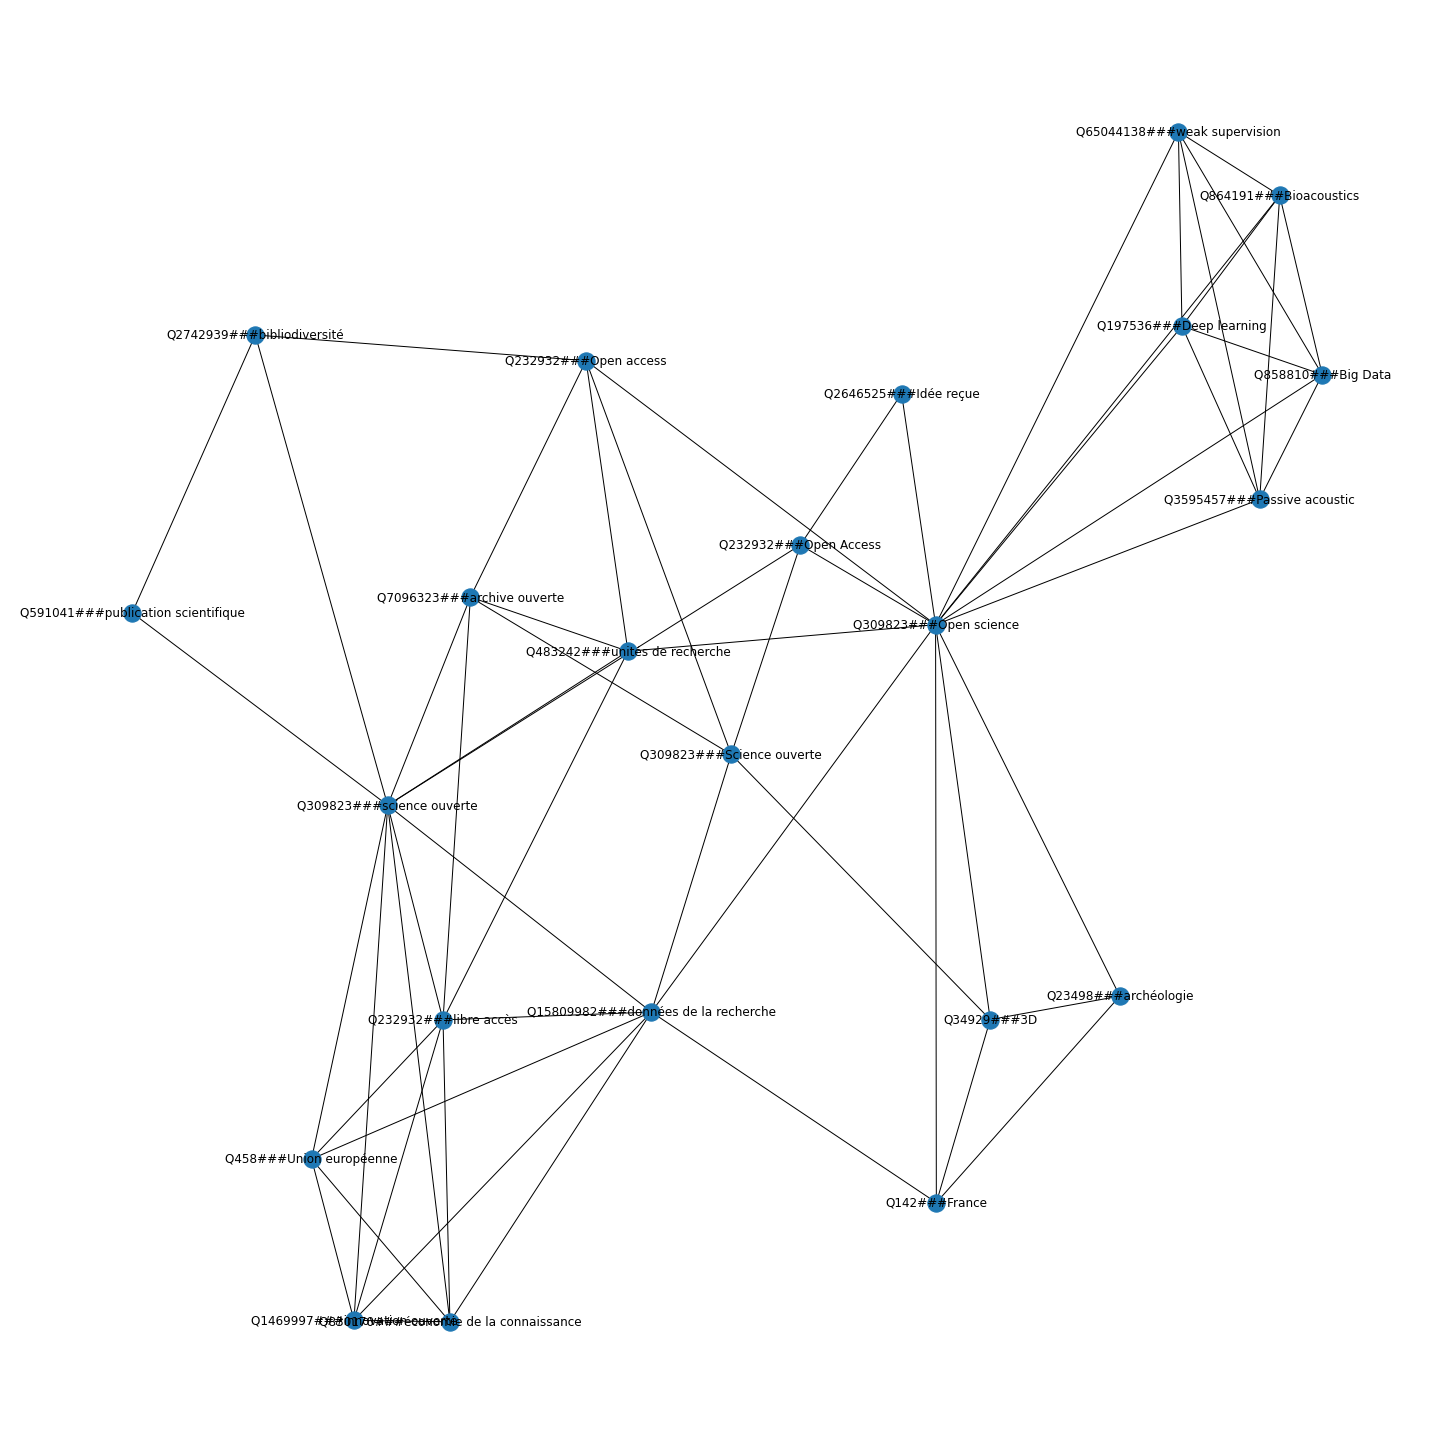

In [20]:
# Draw network
plt.figure(figsize=(20,20))
nx.draw(G2, pos=nx.spring_layout(G2), with_labels = True)
plt.draw()

In [ ]:
sorted(nodes.values(), key=lambda x:x['nb_works'], reverse=True)